In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
# from torchmetrics import Accuracy, Precision, Recall

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from timeit import default_timer as timer
import time
from tqdm import tqdm

%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.12.1+cu116
torchvision version: 0.13.1+cu116


Get Dataset

In [2]:
fmnist_train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

fmnist_test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

Analyze Data

In [3]:
# See first training image
image, label = fmnist_train[0]
print(f"Image shape: {image.shape}")

Image shape: torch.Size([1, 28, 28])


In [4]:
# Data samples
print(f"Number of training samples: {len(fmnist_train)}")
print(f"Number of test samples: {len(fmnist_test)}")

Number of training samples: 60000
Number of test samples: 10000


In [5]:
# See classes
class_names = fmnist_train.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


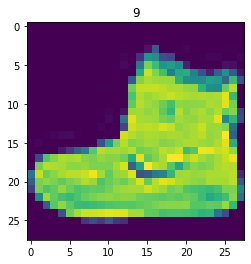

In [6]:
import matplotlib.pyplot as plt
image, label = fmnist_train[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

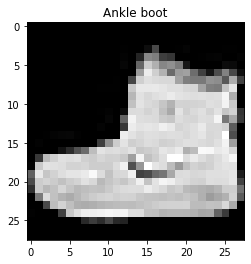

In [7]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

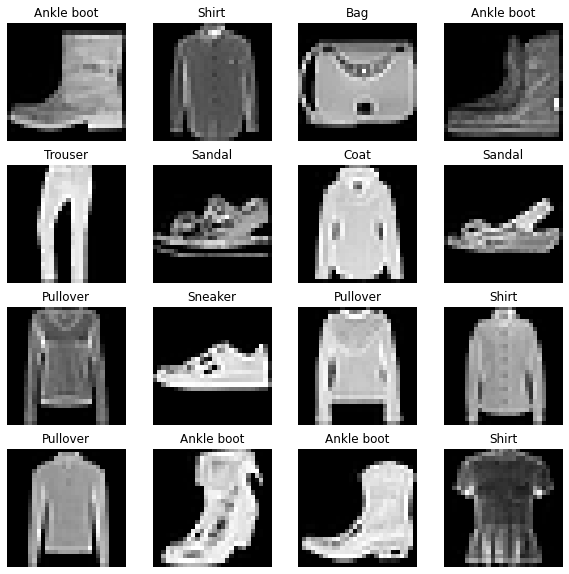

In [8]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(fmnist_train), size=[1]).item()
    img, label = fmnist_train[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

Prepare Dataloader

In [9]:
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(fmnist_train, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

test_dataloader = DataLoader(fmnist_test, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False)

print(f"Number of batches in training dataloader: {len(train_dataloader)}")
print(f"Number of batches in test dataloader: {len(test_dataloader)}")

Number of batches in training dataloader: 1875
Number of batches in test dataloader: 313


In [10]:
# Training dataloader 
train_features_batch, train_labels_batch = iter(train_dataloader).next()
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Label: 6, Class: Shirt
Image shape: torch.Size([1, 28, 28])


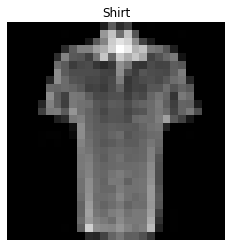

In [11]:
# Visualize image in batch
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);
plt.axis(False)
print(f"Label: {label}, Class: {class_names[label]}")
print(f"Image shape: {image.shape}")
plt.show()

In [12]:
CRITERION = nn.CrossEntropyLoss()
EPOCHS = 20

In [13]:
from trainer import fit_model, evaluate_model, make_predictions, make_sample_predictions
from utils import print_train_time

Baseline 2 (CNN)

In [14]:
from networks import FMnistModelV2

In [15]:
torch.manual_seed(42)
INPUT_SIZE = fmnist_train[0][0].data.shape
print(f"Input size: {INPUT_SIZE}")

model_2 = FMnistModelV2(input_shape=INPUT_SIZE, 
                        hidden_units=64, 
                        output_shape=len(class_names),
                        batch_size=BATCH_SIZE,
                        ).to(DEVICE)

summary(model_2, input_size=fmnist_train[0][0].data.unsqueeze(0).shape, device=DEVICE)

Input size: torch.Size([1, 28, 28])


Layer (type:depth-idx)                   Output Shape              Param #
FMnistModelV2                            [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           36,928
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 64, 14, 14]           --
├─Sequential: 1-2                        [1, 64, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 64, 14, 14]           36,928
│    └─ReLU: 2-7                         [1, 64, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 64, 14, 14]           36,928
│    └─ReLU: 2-9                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-10                   [1, 64, 8, 8]             --
├─


Training FMnistModelV2 model...
Epoch  1/20


100%|██████████| 1875/1875 [00:11<00:00, 166.74it/s]


	Train loss: 0.6505 - Val loss: 0.4214 | Train acc: 0.77 - Val acc: 0.85
Epoch  2/20


100%|██████████| 1875/1875 [00:10<00:00, 170.77it/s]


	Train loss: 0.3793 - Val loss: 0.3529 | Train acc: 0.86 - Val acc: 0.87
Epoch  3/20


100%|██████████| 1875/1875 [00:10<00:00, 173.53it/s]


	Train loss: 0.3255 - Val loss: 0.3206 | Train acc: 0.88 - Val acc: 0.89
Epoch  4/20


100%|██████████| 1875/1875 [00:10<00:00, 171.50it/s]


	Train loss: 0.2948 - Val loss: 0.3067 | Train acc: 0.90 - Val acc: 0.89
Epoch  5/20


100%|██████████| 1875/1875 [00:11<00:00, 168.59it/s]


	Train loss: 0.2741 - Val loss: 0.2948 | Train acc: 0.90 - Val acc: 0.90
Epoch  6/20


100%|██████████| 1875/1875 [00:11<00:00, 169.90it/s]


	Train loss: 0.2572 - Val loss: 0.2811 | Train acc: 0.91 - Val acc: 0.90
Epoch  7/20


100%|██████████| 1875/1875 [00:10<00:00, 173.00it/s]


	Train loss: 0.2434 - Val loss: 0.2672 | Train acc: 0.91 - Val acc: 0.90
Epoch  8/20


100%|██████████| 1875/1875 [00:10<00:00, 171.53it/s]


	Train loss: 0.2321 - Val loss: 0.2640 | Train acc: 0.92 - Val acc: 0.91
Epoch  9/20


100%|██████████| 1875/1875 [00:10<00:00, 171.60it/s]


	Train loss: 0.2213 - Val loss: 0.2602 | Train acc: 0.92 - Val acc: 0.91
Epoch 10/20


100%|██████████| 1875/1875 [00:10<00:00, 171.43it/s]


	Train loss: 0.2128 - Val loss: 0.2622 | Train acc: 0.92 - Val acc: 0.91
Epoch 11/20


100%|██████████| 1875/1875 [00:10<00:00, 171.85it/s]


	Train loss: 0.2042 - Val loss: 0.2550 | Train acc: 0.93 - Val acc: 0.91
Epoch 12/20


100%|██████████| 1875/1875 [00:10<00:00, 172.90it/s]


	Train loss: 0.1955 - Val loss: 0.2460 | Train acc: 0.93 - Val acc: 0.91
Epoch 13/20


100%|██████████| 1875/1875 [00:11<00:00, 170.23it/s]


	Train loss: 0.1879 - Val loss: 0.2377 | Train acc: 0.93 - Val acc: 0.92
Epoch 14/20


100%|██████████| 1875/1875 [00:10<00:00, 170.89it/s]


	Train loss: 0.1813 - Val loss: 0.2410 | Train acc: 0.93 - Val acc: 0.91
Epoch 15/20


100%|██████████| 1875/1875 [00:11<00:00, 168.45it/s]


	Train loss: 0.1741 - Val loss: 0.2495 | Train acc: 0.94 - Val acc: 0.91
Epoch 16/20


100%|██████████| 1875/1875 [00:10<00:00, 170.91it/s]


	Train loss: 0.1689 - Val loss: 0.2350 | Train acc: 0.94 - Val acc: 0.92
Epoch 17/20


100%|██████████| 1875/1875 [00:11<00:00, 169.70it/s]


	Train loss: 0.1616 - Val loss: 0.2301 | Train acc: 0.94 - Val acc: 0.92
Epoch 18/20


100%|██████████| 1875/1875 [00:11<00:00, 169.56it/s]


	Train loss: 0.1552 - Val loss: 0.2439 | Train acc: 0.94 - Val acc: 0.92
Epoch 19/20


100%|██████████| 1875/1875 [00:10<00:00, 174.32it/s]


	Train loss: 0.1500 - Val loss: 0.2455 | Train acc: 0.95 - Val acc: 0.92
Epoch 20/20


100%|██████████| 1875/1875 [00:11<00:00, 170.15it/s]


	Train loss: 0.1441 - Val loss: 0.2645 | Train acc: 0.95 - Val acc: 0.91

Training time on cuda: 244.73 seconds


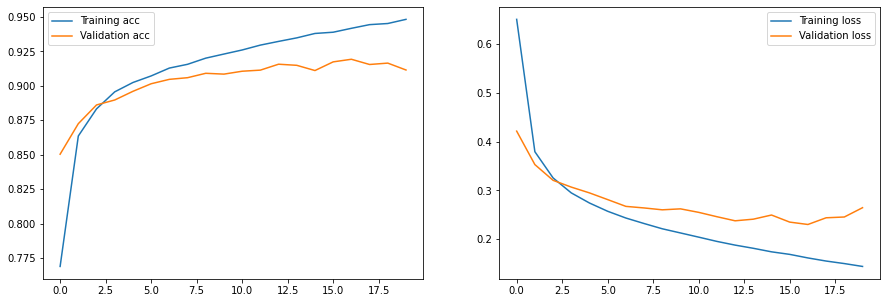

In [16]:
# Train model
# Model 2
OPTIMIZER = torch.optim.SGD(model_2.parameters(), lr=0.01)

history = fit_model(model_2, 
                   loss_fn=CRITERION, 
                   optimizer=OPTIMIZER, 
                   train_loader=train_dataloader,   
                   test_loader=test_dataloader,
                   device=DEVICE,
                   config={
                       "epochs": EPOCHS,
                   })

In [17]:
# Evaluate model
model_2_eval = evaluate_model(model_2, 
                      loss_fn=CRITERION, 
                      dataloader=test_dataloader, 
                      device=DEVICE)
model_2_eval

100%|██████████| 313/313 [00:01<00:00, 189.12it/s]


{'model_name': 'FMnistModelV2',
 'model_loss': '0.2645',
 'model accuracy': '0.91'}

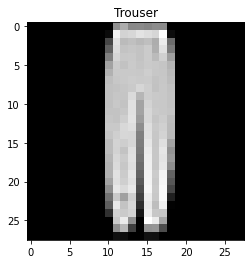

In [18]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(fmnist_test), k=9):
    test_samples.append(sample)
    test_labels.append(label)

index = 0
plt.imshow(test_samples[index].squeeze(), cmap="gray")
plt.title(class_names[test_labels[index]]);

In [19]:
predictions, t_predictions = make_sample_predictions(model_2, data=test_samples, device=DEVICE)

print(f"Label: {test_labels}")
predicted_classes = t_predictions.argmax(dim=1)
print(f"Prediction: {predicted_classes}")

Making predictions ...: 100%|██████████| 9/9 [00:00<00:00, 1518.51it/s]

Label: [1, 0, 9, 3, 2, 7, 1, 9, 9]
Prediction: tensor([1, 0, 9, 3, 2, 7, 1, 7, 9])


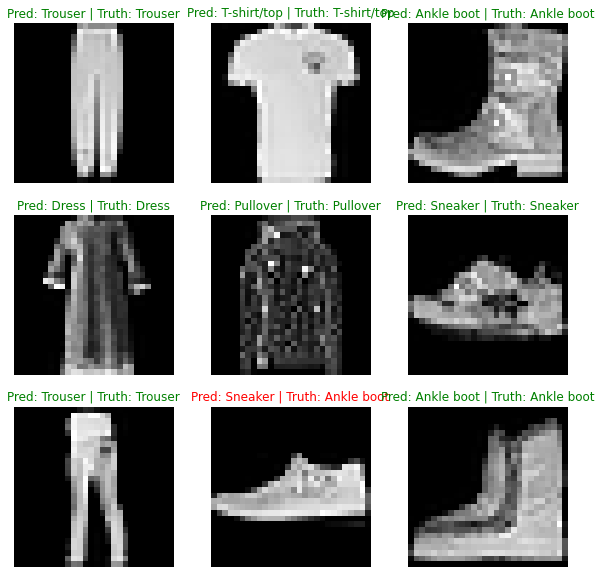

In [20]:
# Plot predictions
plt.figure(figsize=(10, 10))
for i in range(len(test_samples)):
   
    plt.subplot(3, 3, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap="gray")
    
    pred_label = class_names[predicted_classes[i]]
    truth_label = class_names[test_labels[i]]
    
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"    
    
    if pred_label == truth_label:
        plt.title(title_text, color="green")
    else:
        plt.title(title_text, color="red")
    plt.axis(False)

100%|██████████| 313/313 [00:01<00:00, 238.32it/s]


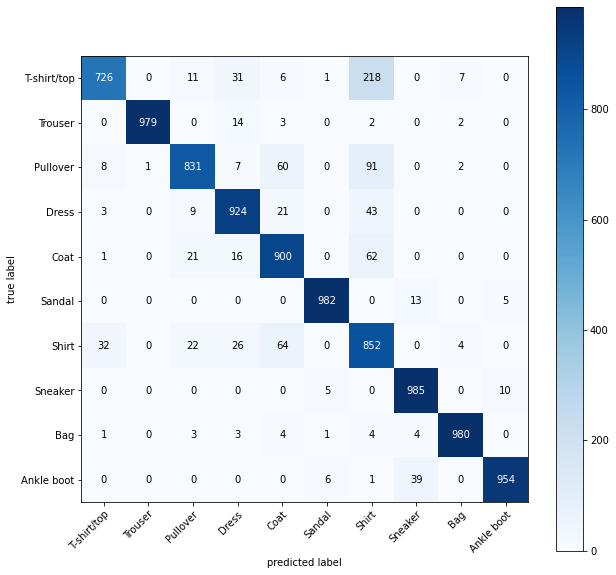

In [21]:
preds, truth_labels = make_predictions(model_2, 
                                       dataloader=test_dataloader, 
                                       device=DEVICE, 
                                       plot_cm=True, 
                                       class_names=class_names)

Load Model

In [22]:
MODEL_PATH = "logs/FMnistModelV2_1663961711/FMnistModelV2_1663961711.pth"

# Load model
transfer_model = FMnistModelV2(input_shape=INPUT_SIZE, 
                               hidden_units=64, 
                               output_shape=len(class_names),
                               batch_size=BATCH_SIZE,
                               ).to(DEVICE)
transfer_model.load_state_dict(torch.load(f=MODEL_PATH))

summary(transfer_model, input_size=(1, 1, 28, 28), device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
FMnistModelV2                            [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           36,928
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 64, 14, 14]           --
├─Sequential: 1-2                        [1, 64, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 64, 14, 14]           36,928
│    └─ReLU: 2-7                         [1, 64, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 64, 14, 14]           36,928
│    └─ReLU: 2-9                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-10                   [1, 64, 8, 8]             --
├─

In [23]:
# Evaluate loaded model
transfer_model_eval = evaluate_model(transfer_model, 
                                     loss_fn=CRITERION, 
                                     dataloader=test_dataloader, 
                                     device=DEVICE)
transfer_model_eval

100%|██████████| 313/313 [00:01<00:00, 240.09it/s]


{'model_name': 'FMnistModelV2',
 'model_loss': '0.2882',
 'model accuracy': '0.92'}

In [24]:
model_2_eval

{'model_name': 'FMnistModelV2',
 'model_loss': '0.2645',
 'model accuracy': '0.91'}